In [1]:
import os
import cv2
import numpy as np

import torch, torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
void = (0, 0, 0)
dirt = (20, 64, 108)
sand = (204, 229, 255)
grass = (0, 102, 0)
tree = (0, 255, 0)
pole = (153, 153, 0)
water = (255, 128, 0)
sky = (255, 0, 0)
vehicle = (0, 255, 255)
container = (127, 0, 255)
asphalt = (64, 64, 64)
gravel = (0, 128, 255)
building = (0, 0, 255)
mulch = (0, 76, 153)
rock_bed = (0, 102, 102)
log = (0, 0, 102)
bicycle = (128, 255, 0)
person = (255, 153, 204)
fence = (204, 0, 102)
bush = (204, 153, 255)
sign = (102, 102, 0)
rock = (255, 204, 153)
bridge = (255, 255, 102)
concrete = (11, 101, 101)
picnic_table = (47, 85, 114)

In [2]:
from torch.utils.data import Dataset
import os
import numpy as np
def get_paths(path):
    _, directories, _ = next(os.walk(path))

    images_paths = []
    for directory in sorted(directories):
        directory_path = os.path.join(path, directory)
        _, _, filenames = next(os.walk(directory_path))
        for filename in sorted(filenames):  
            if filename.endswith('png'):
                images_paths.append(os.path.join(directory_path, filename))
    
    return np.stack(images_paths)

class ObstaclesDataset(Dataset):
    def __init__(self, images, masks):
        self.images = sorted(images)
        self.masks = sorted(masks)
    
    def __len__(self):
        return len(self.masks)
    
    def __getitem__(self, idx):
        image_name = self.images[idx]
        mask_name = self.masks[idx]
        image = cv2.imread(image_name)[:,:,::-1] / 255.0
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        image = transforms.ToTensor()(image[:, :550]).float()
        sample = {
            'image': image,
            'mask': torch.from_numpy(mask[:, :550]).to(torch.uint8),
        }
        return sample

In [3]:
X = get_paths("RUGD_frames-with-annotations")
y = get_paths("RUGD_annotations")

In [4]:
dataset = ObstaclesDataset(X, y)

In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


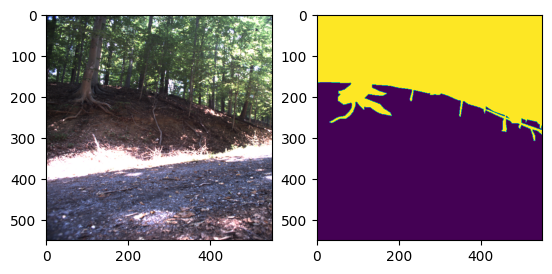

In [30]:
sample = dataset[120]
image = sample['image']
mask = sample['mask']

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)

In [6]:
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()

In [8]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from torchmetrics import JaccardIndex

device = 'cuda'
jaccard = JaccardIndex(task='multiclass', num_classes=2)

def compute_loss(logits, true):
    return nn.CrossEntropyLoss()(logits, true)

def eval_model(model, data_generator):
    IoU = []
    model.train(False)
    with torch.no_grad():
        for batch in data_generator:
            image_batch = batch['image'].to(device)
            mask_batch = batch['mask']
            predictions = model(image_batch).cpu()
            IoU = jaccard(predictions, mask_batch).numpy()
    return np.mean(IoU)

            
def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True)
    for batch in tqdm(train_data_generator):
        optimizer.zero_grad()
        
        image_batch = batch['image'].to(device)
        mask_batch = batch['mask'].to(device)
        predictions = model(image_batch)
        loss = compute_loss(predictions, mask_batch.to(torch.long))
        
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, test_data_generator, num_epochs):
    metrics = {'train_loss': [], 'test_iou': []}
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train_model(model, optimizer, train_data_generator)
        test_iou = eval_model(model, test_data_generator)
        
        metrics['train_loss'].append(train_loss)
        metrics['test_iou'].append(test_iou * 100)
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(history)
            plt.grid()
        plt.show()
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  test iou: \t\t\t{:.2f} %".format(test_iou * 100))

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=8,
                                              shuffle=True,
                                              num_workers=4)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=8,
                                              shuffle=True,
                                              num_workers=4)

In [11]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pad = nn.ConstantPad2d(5, 0)
        self.layer1 = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                              nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU())
        
        self.layer2 = nn.Sequential(nn.MaxPool2d(2), 
                                    nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                                    nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU())
        self.layer3 = nn.Sequential(nn.MaxPool2d(2), 
                                    nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
                                    nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU())
        self.layer4 = nn.Sequential(nn.MaxPool2d(2), 
                                    nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
                                    nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU())
        self.bottom = nn.Sequential(nn.MaxPool2d(2), 
                                    nn.Conv2d(512, 1024, 3, padding=1), nn.BatchNorm2d(1024), nn.ReLU(),
                                    nn.Conv2d(1024, 1024, 3, padding=1), nn.BatchNorm2d(1024), nn.ReLU())
        
        self.up_conv1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.up_conv2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.up_conv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up_conv4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        
        self.up_layer1 = nn.Sequential(nn.Conv2d(1024, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
                          nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU())
        self.up_layer2 = nn.Sequential(nn.Conv2d(512, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
                          nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU())
        self.up_layer3 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                          nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU())
        self.up_layer4 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU())
        
        self.final_conv = nn.Conv2d(64, 2, 1)
        
    def forward(self, image):
        image = self.pad(image)
        layer1 = self.layer1(image)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        bottom = self.bottom(layer4)
        
        up_conv1 = self.up_conv1(bottom)
        crop_layer4 = transforms.functional.center_crop(layer4, (up_conv1.shape[2], up_conv1.shape[3]))
        up_layer1 = self.up_layer1(torch.cat((crop_layer4, up_conv1), dim=1))
        
        up_conv2 = self.up_conv2(up_layer1)
        crop_layer3 = transforms.functional.center_crop(layer3, (up_conv2.shape[2], up_conv2.shape[3]))
        up_layer2 = self.up_layer2(torch.cat((crop_layer3, up_conv2), dim=1))
        
        up_conv3 = self.up_conv3(up_layer2)
        crop_layer2 = transforms.functional.center_crop(layer2, (up_conv3.shape[2], up_conv3.shape[3]))
        up_layer3 = self.up_layer3(torch.cat((crop_layer2, up_conv3), dim=1))
        
        up_conv4 = self.up_conv4(up_layer3)
        crop_layer1 = transforms.functional.center_crop(layer1, (up_conv4.shape[2], up_conv4.shape[3]))
        up_layer4 = self.up_layer4(torch.cat((crop_layer1, up_conv4), dim=1))
        crop_up_layer4 = transforms.functional.center_crop(up_layer4, (550, 550))
        output = self.final_conv(crop_up_layer4)
        return output

In [12]:
unet_model = nn.DataParallel(UNet()).to(device)

In [ ]:
opt = torch.optim.Adam(unet_model.parameters())
train_loop(unet_model, opt, train_loader, test_loader, num_epochs=20)

/tmp/ipykernel_34/3946563816.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_mask = unet_model(torch.unsqueeze(torch.tensor(test_dataset[100]['image']), dim=0).to(device))


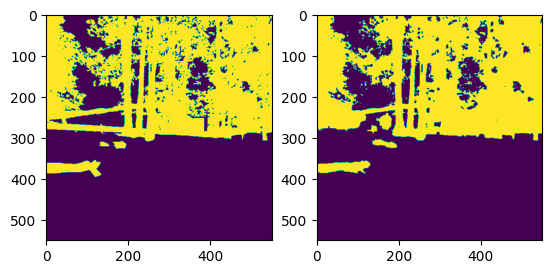

In [60]:
with torch.no_grad():
    pred_mask = unet_model(torch.unsqueeze(torch.tensor(test_dataset[100]['image']), dim=0).to(device))
plt.subplot(1, 2, 1)
plt.imshow(test_dataset[100]['mask'])
plt.subplot(1, 2, 2)
plt.imshow(pred_mask.argmax(dim=1).squeeze().cpu())

/tmp/ipykernel_34/688406433.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_mask = unet_model(torch.unsqueeze(torch.tensor(test_dataset[200]['image']), dim=0).to(device))


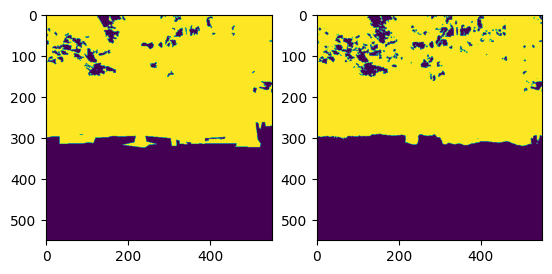

In [37]:
with torch.no_grad():
    pred_mask = unet_model(torch.unsqueeze(torch.tensor(test_dataset[200]['image']), dim=0).to(device))
plt.subplot(1, 2, 1)
plt.imshow(test_dataset[200]['mask'])
plt.subplot(1, 2, 2)
plt.imshow(pred_mask.argmax(dim=1).squeeze().cpu())

/tmp/ipykernel_34/3501503773.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_mask = unet_model(torch.unsqueeze(torch.tensor(test_dataset[600]['image']), dim=0).to(device))


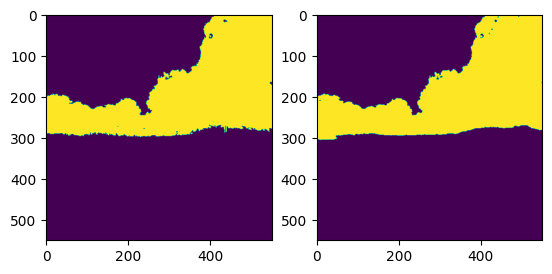

In [40]:
with torch.no_grad():
    pred_mask = unet_model(torch.unsqueeze(torch.tensor(test_dataset[600]['image']), dim=0).to(device))
plt.subplot(1, 2, 1)
plt.imshow(test_dataset[600]['mask'])
plt.subplot(1, 2, 2)
plt.imshow(pred_mask.argmax(dim=1).squeeze().cpu())